In [3]:
!pip install -U datasets
!pip install transformers accelerate evaluate bert_score bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [7]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch

# Load model with optimized settings
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Increase dataset size while keeping runtime manageable
dataset = load_dataset("roneneldan/TinyStories", split="train[:5%]")  # 5% (~100K samples)

# Optimized tokenization with dynamic padding
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,  # Increased context for better coherence
        padding=False  # Dynamic padding handled by collator
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# Enhanced training configuration
training_args = TrainingArguments(
    output_dir="./babygpt-model",
    per_device_train_batch_size=16,  # Increased batch size
    num_train_epochs=2,              # Added second epoch
    save_strategy="no",
    logging_steps=50,
    eval_strategy="no",
    learning_rate=3e-5,              # Tuned learning rate
    weight_decay=0.01,               # Regularization
    fp16=True,
    report_to="none",
    gradient_accumulation_steps=2,   # Memory optimization
    warmup_steps=100,                # Better learning curve
)

# Dynamic padding for efficient memory usage
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=64  # Optimizes GPU memory alignment
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()


Map:   0%|          | 0/105986 [00:00<?, ? examples/s]

/tmp/ipython-input-7-3578373368.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.451600
100,2.131500
150,2.015400
200,1.965000
250,1.947200
300,1.914900
350,1.895900
400,1.881800
450,1.869100
500,1.840500


TrainOutput(global_step=6626, training_loss=1.6925465779257007, metrics={'train_runtime': 5468.7275, 'train_samples_per_second': 38.761, 'train_steps_per_second': 1.212, 'total_flos': 2.7693297303552e+16, 'train_loss': 1.6925465779257007, 'epoch': 2.0})

Model & tokenizer saved to './babygpt-model'

 Training loss plot saved


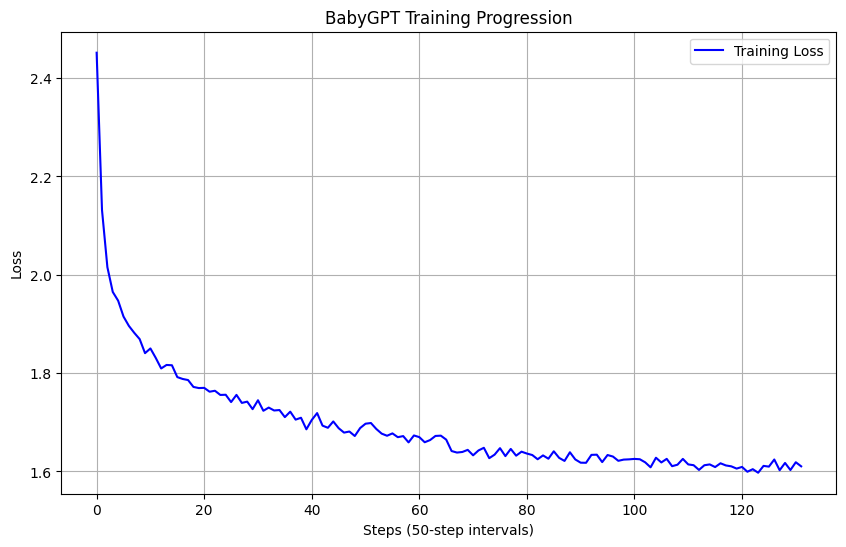

In [8]:
# Save the final model and tokenizer
model.save_pretrained("./babygpt-model")
tokenizer.save_pretrained("./babygpt-model")
print("Model & tokenizer saved to './babygpt-model'")

# Visualization of training results
import matplotlib.pyplot as plt
import pandas as pd

# Extract training logs
logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Filter and plot training loss
train_loss = df[df['loss'].notnull()].reset_index()
plt.figure(figsize=(10, 6))
plt.plot(train_loss.index, train_loss['loss'], 'b-', label='Training Loss')
plt.title('BabyGPT Training Progression')
plt.xlabel('Steps (50-step intervals)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('./babygpt-model/training_loss.png')
print("\n Training loss plot saved")


In [14]:
# Test generation with kid-friendly prompts
test_prompts = [
    "Once upon a time, there was a little fox who loved",
    "The magical tree in the forest could",
    "Lucy and her puppy decided to",
    "In a land of talking animals,",
    "The brave knight rescued a"
]

print("\n Generated Stories")
for i, prompt in enumerate(test_prompts):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=150,  # Increased for complete endings
        do_sample=True,
        temperature=0.65,    # Slightly less random
        top_k=30,
        top_p=0.92,
        repetition_penalty=1.3,  # Stronger anti-repetition
        no_repeat_ngram_size=3,  # Prevent 3-word repeats
        early_stopping=True      # Stop at natural conclusion
    )

    story = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n Prompt #{i+1}: {prompt}\n{'-'*50}")
    print(story)
    print("="*100)

# Enhanced quality metrics
print("\n Evaluating Sample Quality...")
reference = "The little fox discovered a hidden path that led to a magical garden full of friendly animals."

# Generate text for evaluation
inputs = tokenizer("The little fox", return_tensors="pt").to(model.device)
generated = model.generate(
    **inputs,
    max_new_tokens=30,
    do_sample=True,
    temperature=0.7,
    top_k=40,
    top_p=0.9
)
generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)

# print the reference and the generated text
print(f"\nReference: {reference}")
print(f"Generated: {generated_text}")

# Try BERTScore
try:
    from evaluate import load
    bertscore = load("bertscore")

    results = bertscore.compute(
        predictions=[generated_text],
        references=[reference],
        lang="en"
    )
    print(f"\n BERTScore: {results['f1'][0]:.3f} (1.0 is perfect)")
except Exception as e:
    print(f"\n BERTScore unavailable: {str(e)}")
    print("Using simpler metrics instead...")

    # Calculate basic similarity metrics
    from difflib import SequenceMatcher
    from nltk.translate.bleu_score import sentence_bleu

    # Sequence similarity
    similarity = SequenceMatcher(None, reference, generated_text).ratio()
    print(f"Text Similarity: {similarity:.3f}")

    # BLEU score (if nltk available)
    try:
        import nltk
        nltk.download('punkt', quiet=True)
        reference_tokens = [nltk.word_tokenize(reference)]
        generated_tokens = nltk.word_tokenize(generated_text)
        bleu = sentence_bleu(reference_tokens, generated_tokens)
        print(f"BLEU Score: {bleu:.3f}")
    except:
        print("BLEU score unavailable")

# Then we are done !
print("\n All tasks completed! Model is ready for kid-friendly storytelling")

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Generated Stories


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Prompt #1: Once upon a time, there was a little fox who loved
--------------------------------------------------
Once upon a time, there was a little fox who loved to play with his friends. One day he saw something very interesting in the sky and decided it would be fun to fly up high into the clouds! He tried to jump but couldn't do anything because of the wind blowing away everything around him like flies flying on the grass.
 
The next morning, the sun went down really fast as usual so the ground started to dry out for the night. The other animals were still asleep when the big storm came along - they had been waiting patiently all week long until finally the rain stopped falling again just before dawn. 

 From that point onwards everyone knew what to expect from this unusual event if they ever wanted to stay awake one more afternoon at night after dark. So each animal made an effort to


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Prompt #2: The magical tree in the forest could
--------------------------------------------------
The magical tree in the forest could be seen from all around. One day, a little girl named Lily found her toy car on the path and decided to go explore it further than usual.
 
Lily ran up to the big hill she was looking for when suddenly she saw something strange - a beautiful flower! She smiled as she carefully picked it out of her basket and held it close to her hand. 

Suddenly an angry man appeared at the top of that hill. He shouted loudly "Hey there, you two!" The boy had no idea what he meant, so he quickly took his stick away. Then he said: â€œI'm going down this scary mountain nowâ˜and I want to get my weapon back!' And with one last


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Prompt #3: Lucy and her puppy decided to
--------------------------------------------------
Lucy and her puppy decided to go for a walk in the park. As they walked, they saw many things: trees, birds, flowers and animals. Lucy wanted to pet them all at once.
"Let's get ready!" said Lucy. She took two small pups from their arms and ran towards the tree with them. They were so happy that she was able upon a second!

As they got closer together there came a loud noise coming out of nowhere. It sounded like someone shouting "Help me!". 

The dog looked scared but he didn't want it anymore. He just smiled as his owner tried not move him away. Then he slowly stepped into the forest where everyone seemed very friendly.
â€œHello? What are you doing


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Prompt #4: In a land of talking animals,
--------------------------------------------------
In a land of talking animals, there lived two friends named Max and Amy. They were playing together in the garden when they heard an old man's voice coming from behind them.

"What is that?" asked Max. 

Amy looked up at Max with her big eyes. "It was my friend," she said. "I told him to come here first." She walked closer to the woman who had been walking beside them while Dad gave her his watch.
â€œWho are you? What do you want?" asked Amy.
Max nodded eagerly and began to talk about how he could help someone else if it needed their advice. He explained what kind person needs special things like food, shelter or love. His mom smiled as she watched Tommy


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Prompt #5: The brave knight rescued a
--------------------------------------------------
The brave knight rescued a little girl from the wild jungle. She was so happy to be free and she wanted to find out what had happened!

When they arrived, the princess saw that her heart seemed like it could not keep all its parts together. The witch looked around at them with wide eyes and said: "I can help you solve this problem". 


So soon enough as the prince stepped forward, he asked if anyone else knew who would get in touch of their troubles? He answered quietly but then gave his blessing - each one being given something special for helping him overcome any difficulty."He will make sure everyone is safe"â€'. So too did the dragon himself!" shouted Harry sadly waving goodbye â“ until finally an angel appeared nearby

 Evaluating Sample Quality...

Reference: The little fox discovered a hidden path that led to a magical garden full of friendly animals.
Generated: The little fox was walking 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 BERTScore: 0.867 (1.0 is perfect)

 All tasks completed! Model is ready for kid-friendly storytelling
